In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from LearningAlgorithms import ClassificationAlgorithms
import seaborn as sns
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix


# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

df = pd.read_pickle("../../data/interim/03_data_faetures.pkl")

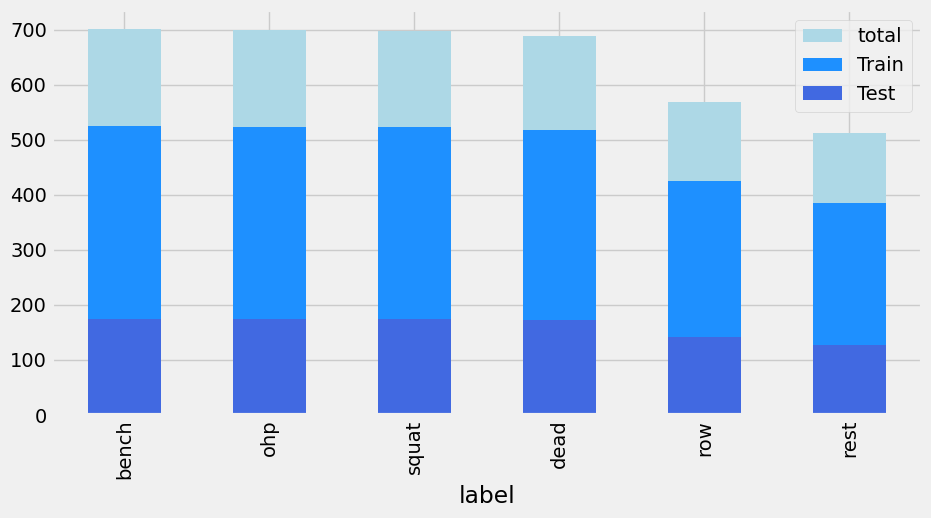

In [ ]:
df_train = df.drop(["participant", "category", "set"], axis=1)
X = df_train.drop("label", axis=1)
y = df_train["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

fig, ax = plt.subplots(figsize=(10, 5))
df_train["label"].value_counts().plot(
    kind="bar", ax=ax, color="lightblue", label="total"
)
y_train.value_counts().plot(kind="bar", ax=ax, color="dodgerblue", label="Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label="Test")
plt.legend()
plt.show()

In [ ]:
basic_features = ["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]
square_features = ["acc_r", "gyr_r"]
pca_features = ["pca_1", "pca_2", "pca_3"]
time_features = [f for f in df_train.columns if "_temp_" in f]
frequency_features = [f for f in df_train.columns if ("_freq" in f) or ("_pse" in f)]
cluster_features = ["cluster"]

# Print the length of each feature list
print("Basic Features Length:", len(basic_features))
print("Square Features Length:", len(square_features))
print("PCA Features Length:", len(pca_features))
print("Time Features Length:", len(time_features))
print("Frequency Features Length:", len(frequency_features))
print("Cluster Features Length:", len(cluster_features))

feature_set_1 = basic_features
feature_set_2 = list(set(basic_features + square_features + pca_features))
feature_set_3 = list(set(feature_set_2 + time_features))
feature_set_4 = list(set(feature_set_3 + frequency_features + cluster_features))

Basic Features Length: 6
Square Features Length: 2
PCA Features Length: 3
Time Features Length: 16
Frequency Features Length: 88
Cluster Features Length: 1


0
1
2
3
4
5
6
7
8
9


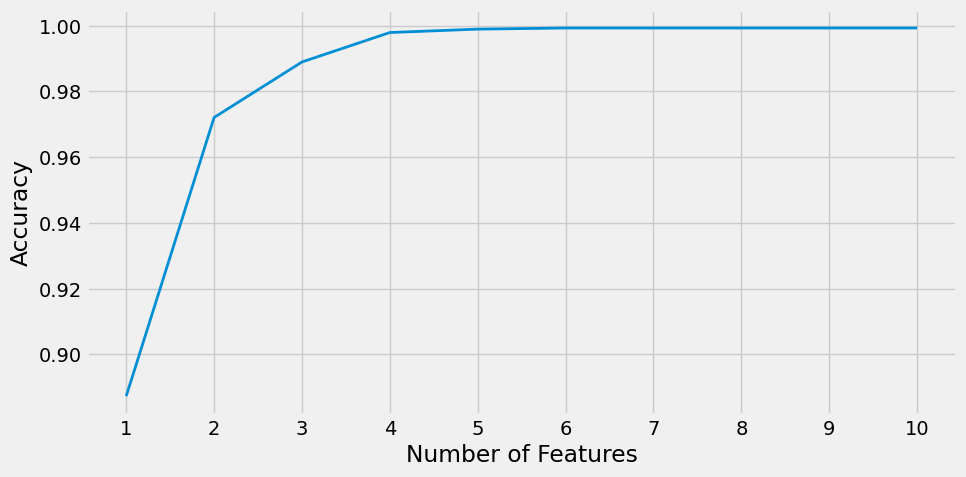

In [ ]:
learner = ClassificationAlgorithms()

max_features = 10
selected_features, ordered_features, ordered_scores = learner.forward_selection(
    max_features, X_train, y_train
)

selected_features = [
    "pca_1",
    "acc_z_temp_mean_ws_5",
    "acc_x_freq_0.0_Hz_ws_14",
    "gyr_r_freq_0.0_Hz_ws_14",
    "acc_z_freq_0.0_Hz_ws_14",
    "gyr_y_temp_mean_ws_5",
    "acc_z_freq_weighted",
    "gyr_r",
    "gyr_r_freq_2.5_Hz_ws_14",
    "gyr_y_freq_0.714_Hz_ws_14",
]
# results could be different for each run due to randomness

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, max_features + 1, 1), ordered_scores)
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, max_features + 1, 1))
plt.show()

In [ ]:
possible_feature_sets = [
    feature_set_1,
    feature_set_2,
    feature_set_3,
    feature_set_4,
    selected_features,
]

feature_names = [
    "Feature Set 1",
    "Feature Set 2",
    "Feature Set 3",
    "Feature Set 4",
    "Selected Features",
]

In [ ]:
iterations = 1  # each model is trained only once, could also train e.g., 5 times then take the average accuracy, due to randomness above
score_df = pd.DataFrame()

In [ ]:
for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=False,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)

        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])

Feature set: 0
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 4
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes


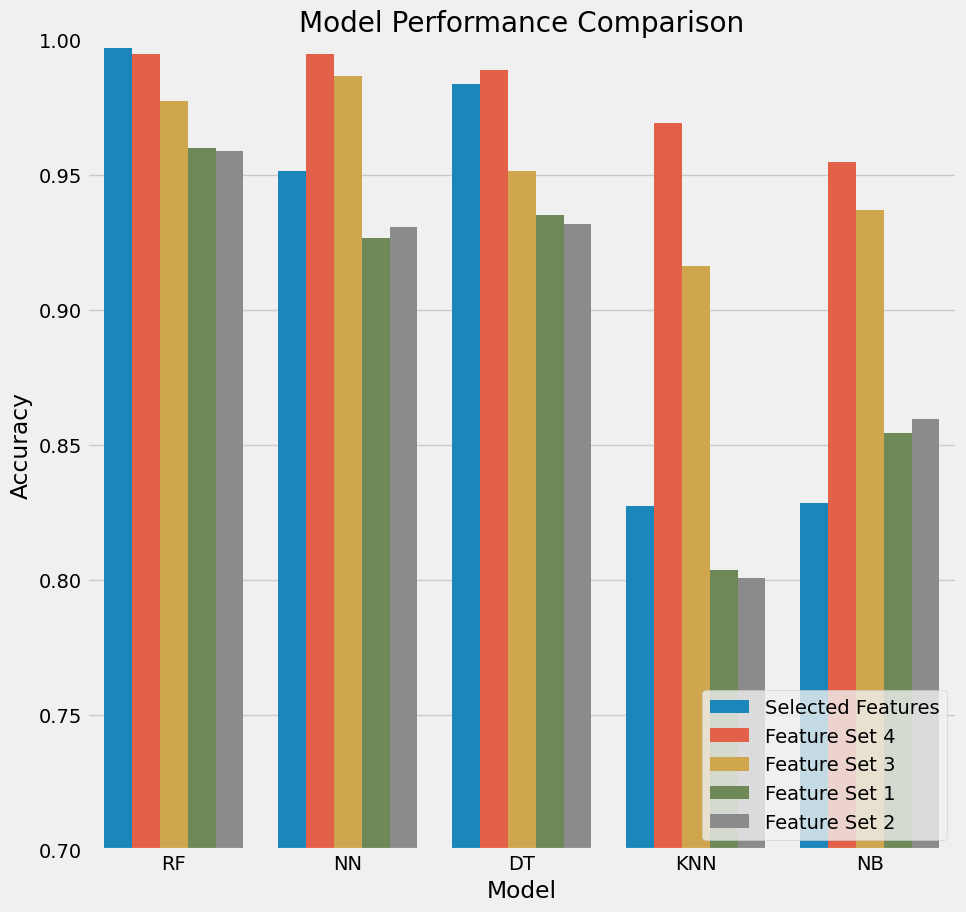

In [ ]:
score_df.sort_values(by="accuracy", ascending=False, inplace=True)

plt.figure(figsize=(10, 10))
sns.barplot(x="model", y="accuracy", hue="feature_set", data=score_df)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0.7, 1)
plt.legend(loc="lower right")
plt.show()

In [ ]:
X_train[feature_set_4]

In [ ]:
X_train[feature_set_4]

,acc_r_freq_0.0_Hz_ws_14,acc_x_temp_mean_ws_5,acc_r_freq_1.071_Hz_ws_14,acc_x_freq_1.071_Hz_ws_14,gyr_x_freq_2.143_Hz_ws_14,acc_z,gyr_r_max_freq,acc_y_freq_1.071_Hz_ws_14,gyr_z_max_freq,gyr_z_freq_0.357_Hz_ws_14,...,gyr_x_freq_2.5_Hz_ws_14,acc_r_freq_0.714_Hz_ws_14,gyr_y,acc_y,acc_r_freq_2.5_Hz_ws_14,gyr_z_freq_0.714_Hz_ws_14,gyr_z_temp_mean_ws_5,acc_y_freq_2.143_Hz_ws_14,pca_3,acc_x_freq_weighted
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-19 17:33:16.800,16.097755,0.004277,-0.401469,0.035953,-20.395559,0.153875,0.0,0.412514,0.714,-13.755800,...,-17.931488,-0.569932,-5.701669,-0.729516,0.441713,55.418853,-3.639746,-0.466865,-0.033941,0.580280
2019-01-15 19:37:28.400,15.269260,0.047704,-0.181560,0.065631,-29.822625,0.014144,0.0,0.168316,0.357,14.810710,...,-28.955709,0.240358,-5.041411,-0.964470,-0.005849,1.068637,1.691915,0.022773,-0.047942,0.098857
2019-01-19 17:22:51.400,14.845132,0.471526,0.672681,1.453689,2.660803,0.449213,0.0,-0.592477,0.357,234.509681,...,2.182249,-0.770187,-5.046822,0.791169,-0.006337,2.301838,8.384813,-0.528724,0.116582,0.254950
2019-01-11 16:24:45.400,15.429188,0.046086,0.384184,-0.055891,2.842760,-0.057986,0.0,-0.402478,0.357,14.844903,...,3.317941,0.761735,-3.070809,-1.233542,0.003207,-0.813607,1.132488,-0.013701,-0.026633,-0.572727
2019-01-20 17:31:03.400,15.442046,0.005534,-1.895341,0.099327,-1.313806,-0.080392,0.0,1.944465,0.357,69.608686,...,-1.607474,-0.040706,-1.945943,-1.040965,-0.181567,-38.153123,8.452551,0.203512,-0.059405,1.762030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-14 13:55:50.000,14.681091,-0.205400,0.078156,-0.004311,-4.129425,-0.251384,0.0,0.076111,0.357,28.316812,...,-3.874464,-0.211092,0.933445,0.758751,0.035093,-45.995816,-1.089565,0.027731,0.006185,0.126245
2019-01-15 14:06:54.200,15.779945,0.083555,0.127521,0.083119,-8.339504,0.045379,0.0,-0.110442,0.000,-6.629597,...,-7.938803,0.958461,-8.389035,-1.308910,0.095764,-62.792282,2.141362,-0.084518,-0.023744,0.179916
2019-01-11 16:24:34.200,15.417168,-0.023977,-0.545357,0.091075,3.664849,0.321965,0.0,0.456614,1.429,-45.596005,...,3.122621,0.163171,2.114324,-0.903080,0.007336,-10.057044,1.504219,0.002635,-0.163296,1.575129


In [ ]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y
) = learner.random_forest(
    X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=True
)

In [ ]:
accuracy = accuracy_score(y_test, class_test_y)
print("Accuracy:", accuracy)

Accuracy: 0.9968976215098242


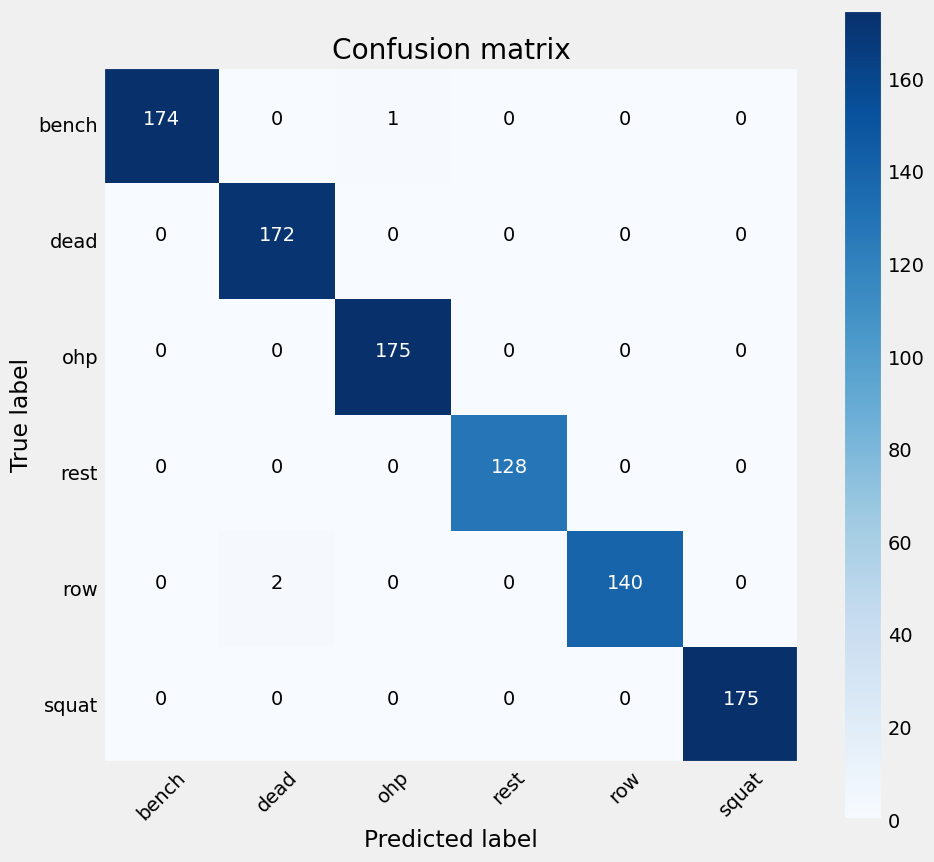

In [ ]:
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

In [ ]:
participant_df = df.drop(["set", "category"], axis=1)

X_train = participant_df[participant_df["participant"] != "A"].drop("label", axis=1)
y_train = participant_df[participant_df["participant"] != "A"]["label"]

X_test = participant_df[participant_df["participant"] == "A"].drop("label", axis=1)
y_test = participant_df[participant_df["participant"] == "A"]["label"]

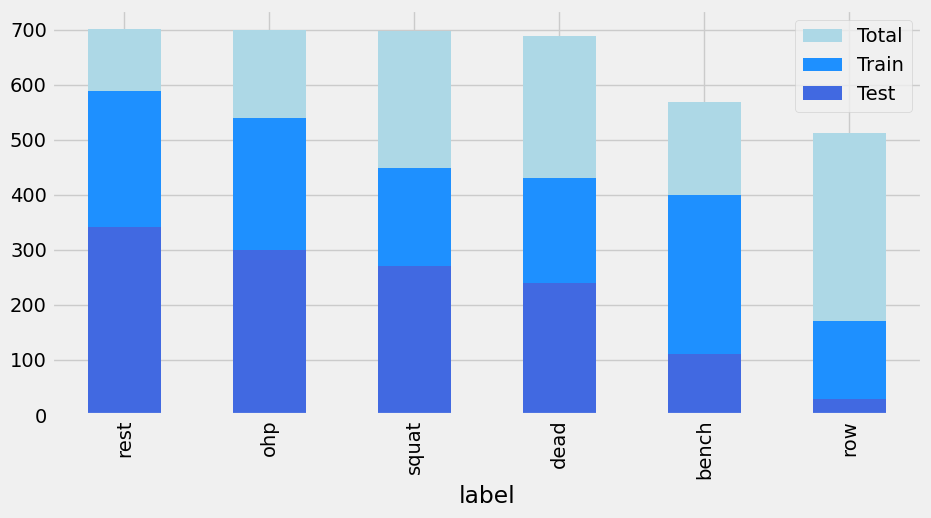

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df_train["label"].value_counts().plot(
    kind="bar", ax=ax, color="lightblue", label="Total"
)

y_train.value_counts().plot(
    kind="bar", ax=ax, color="dodgerblue", label="Train"
)

y_test.value_counts().plot(
    kind="bar", ax=ax, color="royalblue", label="Test"
)

plt.legend()
plt.show()

In [ ]:
y_train.value_counts()

label
bench    588
row      539
dead     449
squat    430
ohp      399
rest     171
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

label
rest     342
ohp      299
squat    271
dead     240
bench    111
row       29
Name: count, dtype: int64

In [ ]:
df_train["label"].value_counts()

label
squat    701
bench    699
ohp      698
dead     689
row      568
rest     513
Name: count, dtype: int64

In [ ]:
df_train["label"].value_counts().sum()

3868

In [ ]:
y_test.value_counts().sum()

1292

In [ ]:
y_train.value_counts().sum()

2576

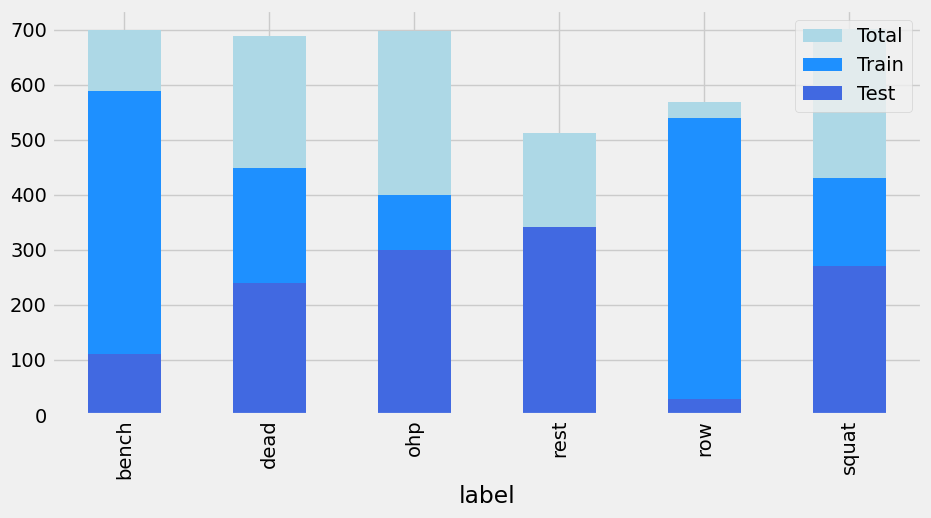

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df_train["label"].value_counts().sort_index().plot(
    kind="bar", ax=ax, color="lightblue", label="Total"
)

y_train.value_counts().sort_index().plot(
    kind="bar", ax=ax, color="dodgerblue", label="Train"
)

y_test.value_counts().sort_index().plot(
    kind="bar", ax=ax, color="royalblue", label="Test"
)

y_train.value_counts().sum()
y_test.value_counts().sum()
df_train["label"].value_counts().sum()

plt.legend()
plt.show()

Accuracy: 0.9938080495356038


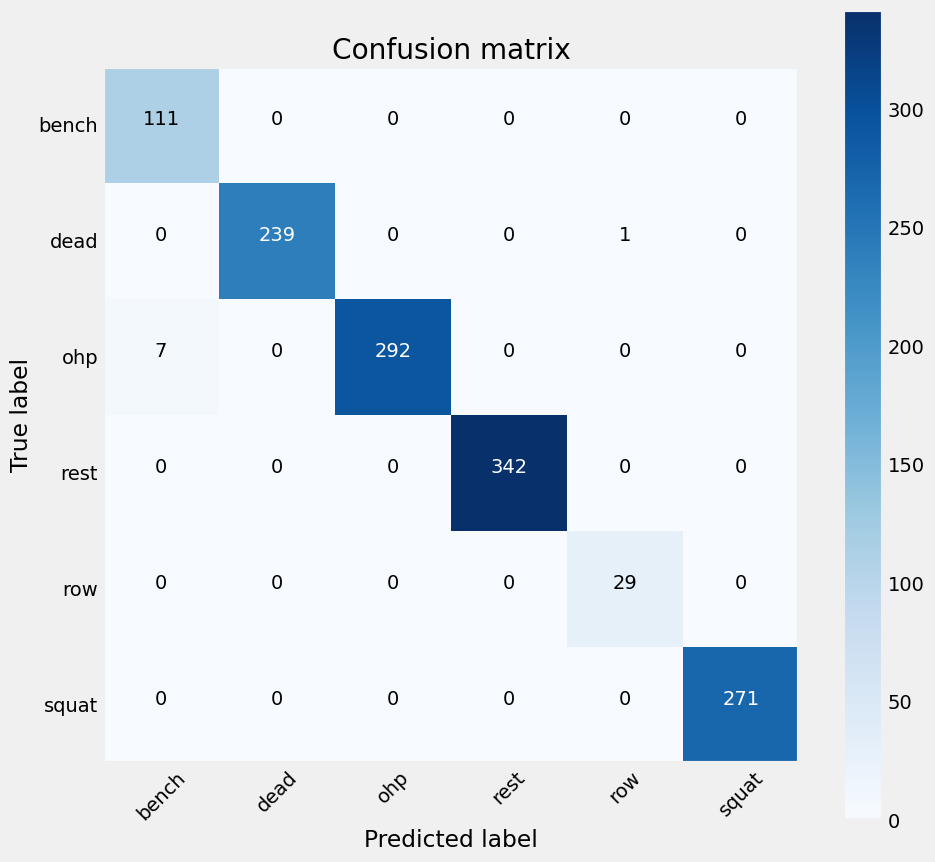

In [ ]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y
) = learner.random_forest(
    X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=True
)

accuracy = accuracy_score(y_test, class_test_y)
print("Accuracy:", accuracy)

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

Accuracy: 0.9705882352941176


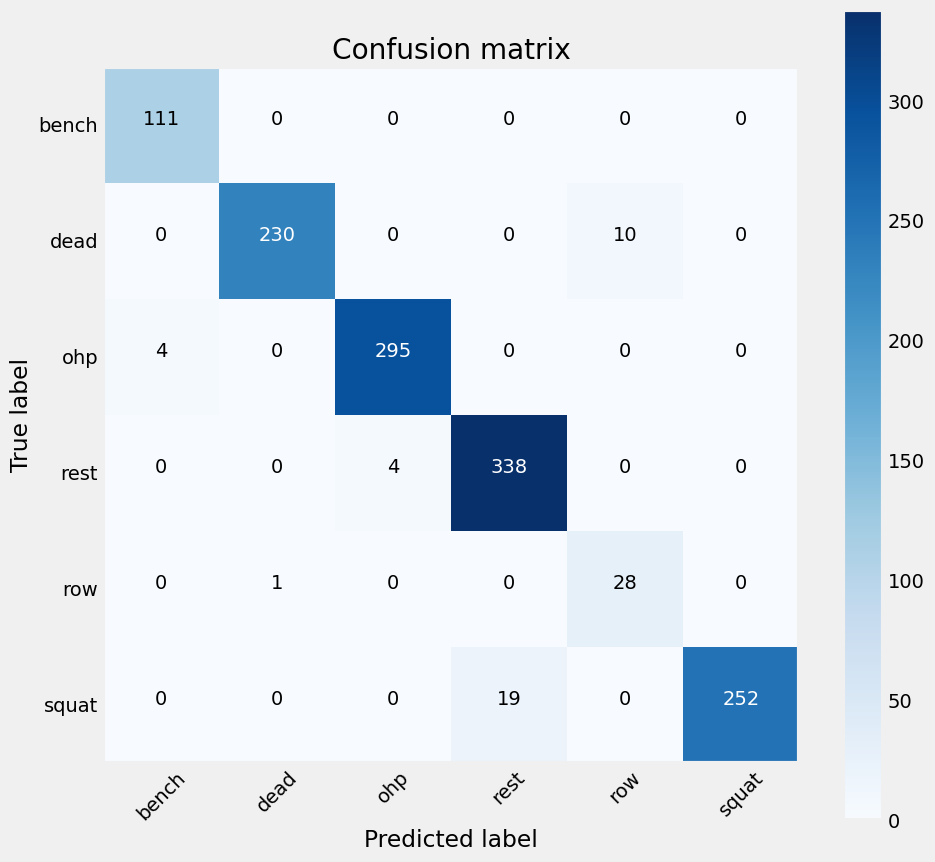

In [ ]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y
) = learner.random_forest(
    X_train[selected_features], y_train, X_test[selected_features], gridsearch=False
)

accuracy = accuracy_score(y_test, class_test_y)
print("Accuracy:", accuracy)

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

Accuracy: 0.9907120743034056


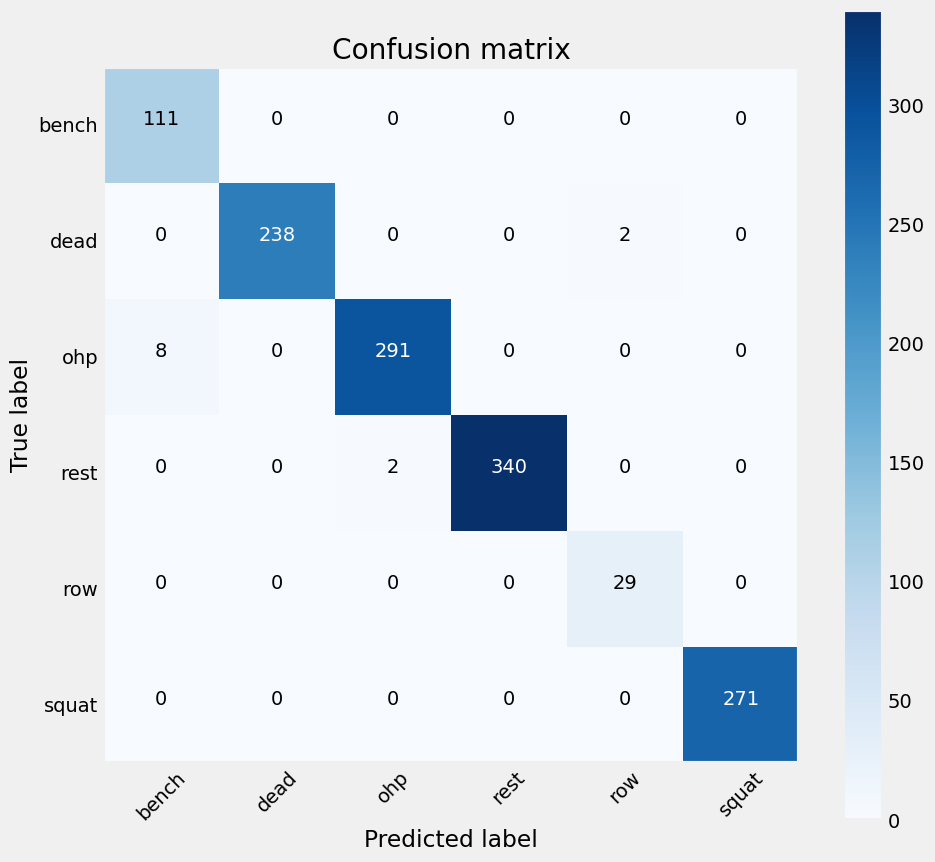

In [ ]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y
) = learner.random_forest(
    X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=False
)

accuracy = accuracy_score(y_test, class_test_y)
print("Accuracy:", accuracy)

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()